# 1. Contextualização
O dataset [Real Estate Saint Petersburg 2014 - 2019](https://www.kaggle.com/datasets/litvinenko630/real-estate-saint-petersburg-2014-2019/data?select=real_estate_data.csv) contém informações sobre anúncios de imóveis na segunda maior cidade da Russia, São Petersburgo, sendo fonte valiosos insights sobre o mercado imobiliário na região. Os dados incluem variáveis que descrevem tanto os imóveis, quanto seus arredores e instalações próximas que podem influenciar no preço. 

## 1.1. Metas e objetivos
O objetivo deste projeto é construir um modelo de machine learning capaz de  predizer o preço de imóveis em São Petersburgo. 

## 1.2. Features

|Coluna|Descrição|
|--|--|
|`airports_nearest`|Distância em metros para o aeroporto mais próximo|
|`balcony`| Número de sacadas|
|`ceiling_height`| Altura em metros do telhado|
|`cityCenters_nearest`| Distância até o centro da cidade em metros|
|`days_exposition`| Número de dias que o anúncio esteve ativo|
|`first_day_exposition`| Data de publicação do anúncio|
|`floor`| Total de andares do imóvel|
|`floors_total`| Total de andares no prédio onde o imóvel está localizado|
|`is_apartment`| Se é um apartamento (bool)|
|`kitchen_area`| Área da cozinha em metros quadrados|
|`last_price`| Último preço de anúncio|
|`living_area`| Área de convivência em metros quadrados|
|`locality_name`| Nome da localidade|
|`open_plan`| Se a propriedade tem um plano aberto (bool)|
|`parks_around3000`| Número de parques em um raio de 3km|
|`parks_nearest`| Distância do parque mais próximo em metros|
|`ponds_around3000`| Número de corpos de água em um raio de 3km|
|`ponds_nearest`| Distância do corpo de água mais próximo|
|`rooms`| Número de quartos|
|`studio`| Se é um apartamento do tipo studio (bool)|
|`total_area`| Área total do imóvel em metros quadrados|
|`total_images`| Número de imagens no anúncio|

# 2. Preparação do ambiente
## 2.1. Importação das bibliotecas e carregamento dos dados

In [45]:
# Manipulação de dados
import pandas as pd
import numpy as np

# Análise Exploratória de Dados
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from xgboost import XGBRegressor

# Pré-processamento
import optuna
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from feature_engine import imputation
from category_encoders import TargetEncoder

# Configurações do notebook
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set_palette('Set1')
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("../data/raw/real_estate_data.csv", sep = '\t')

## 2.2. Revisão dos dados

In [3]:
print(f"Dataset possui {df.shape[0]} linhas e {df.shape[1]} colunas.")

Dataset possui 23699 linhas e 22 colunas.


In [4]:
print(f"O dataset possui: {len(df.select_dtypes(include = 'object').columns.to_list())} colunas categóricas.")
print(f"O dataset possui: {len(df.select_dtypes(include = 'number').columns.to_list())} colunas numéricas.")

O dataset possui: 3 colunas categóricas.
O dataset possui: 17 colunas numéricas.


In [5]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [7]:
df.nunique().sort_values()

studio                     2
open_plan                  2
is_apartment               2
ponds_around3000           4
parks_around3000           4
balcony                    6
rooms                     17
floor                     33
floors_total              36
total_images              38
ceiling_height           183
locality_name            364
kitchen_area             971
parks_nearest            995
ponds_nearest           1096
days_exposition         1141
first_day_exposition    1491
living_area             1782
total_area              2182
last_price              2978
cityCenters_nearest     7642
airports_nearest        8275
dtype: int64

In [8]:
df.isnull().mean()

total_images            0.000000
last_price              0.000000
total_area              0.000000
first_day_exposition    0.000000
rooms                   0.000000
ceiling_height          0.387991
floors_total            0.003629
living_area             0.080299
floor                   0.000000
is_apartment            0.882906
studio                  0.000000
open_plan               0.000000
kitchen_area            0.096122
balcony                 0.486054
locality_name           0.002068
airports_nearest        0.233850
cityCenters_nearest     0.232879
parks_around3000        0.232837
parks_nearest           0.659100
ponds_around3000        0.232837
ponds_nearest           0.615596
days_exposition         0.134225
dtype: float64

In [6]:
colunas = df.isnull().mean()
filtro = colunas[colunas < 0.30].index
df = df[filtro]
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,floors_total,living_area,floor,studio,open_plan,kitchen_area,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,ponds_around3000,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,16.0,51.0,8,False,False,25.0,Санкт-Петербург,18863.0,16028.0,1.0,2.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,11.0,18.6,1,False,False,11.0,посёлок Шушары,12817.0,18603.0,0.0,0.0,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,5.0,34.3,4,False,False,8.3,Санкт-Петербург,21741.0,13933.0,1.0,2.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,14.0,NaN,9,False,False,NaN,Санкт-Петербург,28098.0,6800.0,2.0,3.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,14.0,32.0,13,False,False,41.0,Санкт-Петербург,31856.0,8098.0,2.0,1.0,121.0


Existem muitas colunas com acima de 30% de valores nulos, não iremos utilizar essas colunas por conta da grande perca de informação, essas colunas são: `ceiling_height`, `is_apartment`, `balcony`, `parks_nearest` e `ponds_nearest`. 

In [7]:
df.dtypes

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
floors_total            float64
living_area             float64
floor                     int64
studio                     bool
open_plan                  bool
kitchen_area            float64
locality_name            object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000        float64
ponds_around3000        float64
days_exposition         float64
dtype: object

Mais a frente vamos realizar a transformação das variáveis bool em int.

# 3. Explorando as variáveis
## 3.1. Estatísticas descritivas e distribuição do target

In [11]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
total_images,23699.0,9.86,5.68,0.0,6.0,9.0,14.0,50.0
last_price,23699.0,6541548.77,10887013.27,12190.0,3400000.0,4650000.0,6800000.0,763000000.0
total_area,23699.0,60.35,35.65,12.0,40.0,52.0,69.9,900.0
rooms,23699.0,2.07,1.08,0.0,1.0,2.0,3.0,19.0
floors_total,23613.0,10.67,6.60,1.0,5.0,9.0,16.0,60.0
living_area,21796.0,34.46,22.03,2.0,18.6,30.0,42.3,409.7
floor,23699.0,5.89,4.89,1.0,2.0,4.0,8.0,33.0
kitchen_area,21421.0,10.57,5.91,1.3,7.0,9.1,12.0,112.0
airports_nearest,18157.0,28793.67,12630.88,0.0,18585.0,26726.0,37273.0,84869.0
cityCenters_nearest,18180.0,14191.28,8608.39,181.0,9238.0,13098.5,16293.0,65968.0


A variável target apresenta uma assimétria positiva, e uma alta dispersão. Se tratando de mercado imobiliário perderiamos muita informação ao remover outliers, vamos observar a distribuição visualmente. 

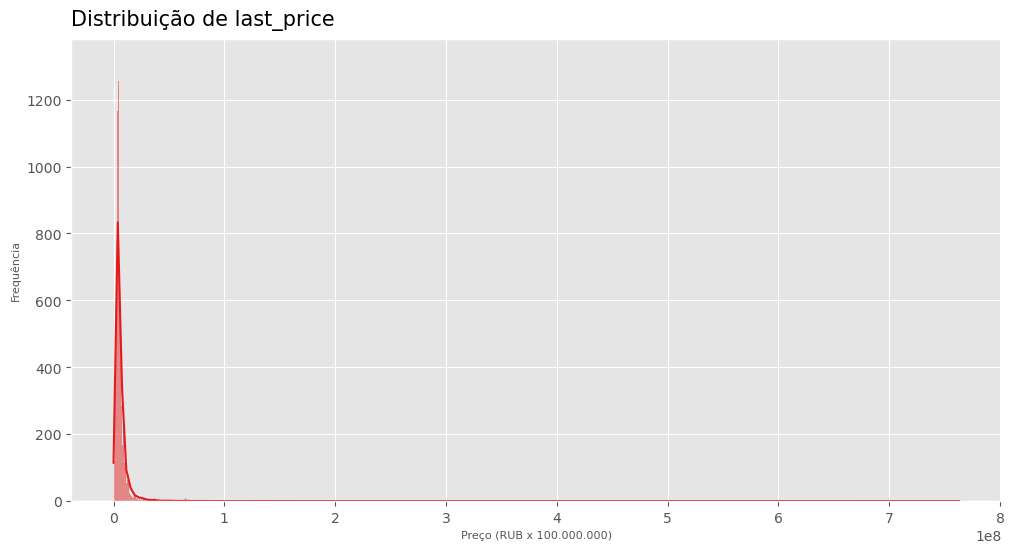

In [12]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.histplot(df.last_price, kde = True)
ax.set_title("Distribuição de last_price", fontsize = 15, pad = 10, loc = 'left')
ax.set_xlabel("Preço (RUB x 100.000.000)", fontsize = 8)
ax.set_ylabel("Frequência", fontsize = 8)
plt.show()

Vou aplicar uma transformação logaritmica ao target para aproximar a distribuição à normal. 

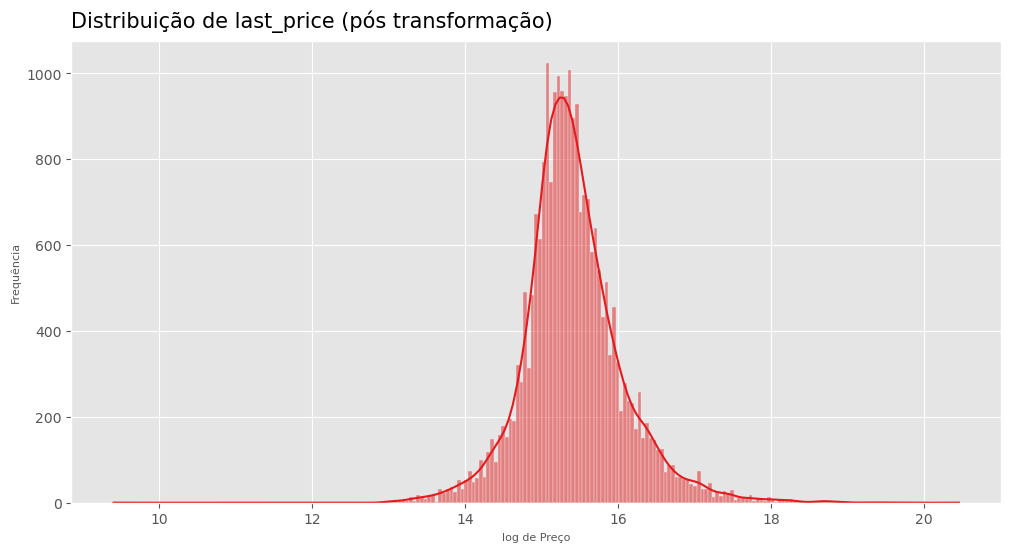

In [13]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.histplot(np.log1p(df.last_price), kde = True)
ax.set_title("Distribuição de last_price (pós transformação)", fontsize = 15, pad = 10, loc = 'left')
ax.set_xlabel("log de Preço", fontsize = 8)
ax.set_ylabel("Frequência", fontsize = 8)
plt.show()

In [8]:
df['log_last_price'] = np.log1p(df['last_price'])
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,floors_total,living_area,floor,studio,open_plan,kitchen_area,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,ponds_around3000,days_exposition,log_last_price
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,16.0,51.0,8,False,False,25.0,Санкт-Петербург,18863.0,16028.0,1.0,2.0,NaN,16.380460
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,11.0,18.6,1,False,False,11.0,посёлок Шушары,12817.0,18603.0,0.0,0.0,81.0,15.024471
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,5.0,34.3,4,False,False,8.3,Санкт-Петербург,21741.0,13933.0,1.0,2.0,558.0,15.463400
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,14.0,NaN,9,False,False,NaN,Санкт-Петербург,28098.0,6800.0,2.0,3.0,424.0,17.988358
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,14.0,32.0,13,False,False,41.0,Санкт-Петербург,31856.0,8098.0,2.0,1.0,121.0,16.118096


## 3.2. Matriz de correlação

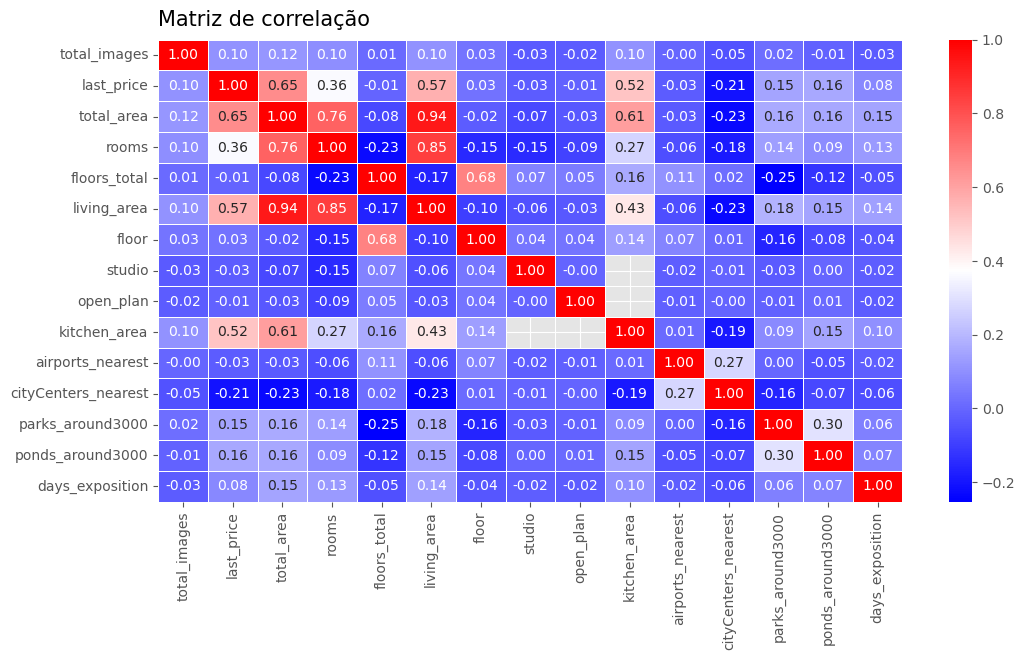

In [15]:
corr = df.drop('log_last_price', axis = 1).corr(numeric_only=True)

fig, ax = plt.subplots(figsize = (12, 6))
sns.heatmap(corr, annot = True, fmt = '.2f', linewidths=0.5, cmap = 'bwr')
ax.set_title("Matriz de correlação", fontsize = 15, pad = 10, loc = 'left')
plt.show()

- Dos fatores relacionados a estrutura do imóvel, a área total, tamanho da cozinha e o espaço de convivência são os que mostram correlação mais forte com o preço. A área total no mercado imobiliário sempre uma variável chave na precificação de um imóvel já que o ponto base da avaliação imobiliária é o preço do metro quadrado na região.
- Dentre os outros fatores, estar longe do centro desvaloriza o imóvel, e ter parques e fontes de água próximas valorizam. 

# 4. Preparação dos dados

## 4.1. Seleção das features

In [9]:
features = df.drop(columns = ['last_price', 'log_last_price', 'first_day_exposition'], axis = 1).columns.to_list()
target = 'log_last_price'

X = df[features]
y = df[target]

### Divisão em treino, validação e teste

In [12]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, random_state=21)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size = 0.25, random_state=21)

## 4.2. Pré-processamento

In [13]:
bool_features = X_train.select_dtypes(include = 'bool').columns.to_list()
num_features = X_train.select_dtypes(include = 'number').columns.to_list()
cat_features = X_train.select_dtypes(include = 'object').columns.to_list()

In [14]:
def bool_to_int(X):
    return X.astype(int)

bool_transformer = Pipeline([
    ('bool_to_int', FunctionTransformer(func = bool_to_int, validate = False)),
    ('imput', SimpleImputer(strategy='most_frequent'))   
])

num_transformer = Pipeline([
    ('imput', imputation.MeanMedianImputer(imputation_method='median'))
])

cat_transformer = Pipeline([
    ('imput', imputation.CategoricalImputer(imputation_method='frequent')),
    ('encoder', TargetEncoder())
])

preprocessor = ColumnTransformer(
    transformers = [
        ('bool', bool_transformer, bool_features),
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ]
)

# 3. Modelo de Regressão

## 3.1. Modelo base

In [15]:
model = XGBRegressor(objective='reg:squarederror', random_state = 42)

reg = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', model)
])

reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('bool',
                                                  Pipeline(steps=[('bool_to_int',
                                                                   FunctionTransformer(func=<function bool_to_int at 0x7f3c56a03e20>)),
                                                                  ('imput',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['studio', 'open_plan']),
                                                 ('num',
                                                  Pipeline(steps=[('imput',
                                                                   MeanMedianImputer())]),
                                                  ['total_images', 'total_area',
                                                   'rooms', 'floors_total'...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [16]:
y_pred = reg.predict(X_val)

In [23]:
print(f"Métricas - Validação\n{"=" * 30}")
print(f"MSE: {metrics.mean_squared_error(y_val, y_pred):.4f}")
print(f"RMSE: {metrics.mean_squared_error(y_val, y_pred, squared = False):.4f}")
print(f"MAE: {metrics.mean_absolute_error(y_val, y_pred):.4f}")
print(f"R2 Score: {metrics.r2_score(y_val, y_pred):.4f}")

Métricas - Validação
MSE: 0.0503
RMSE: 0.2244
MAE: 0.1482
R2 Score: 0.8809


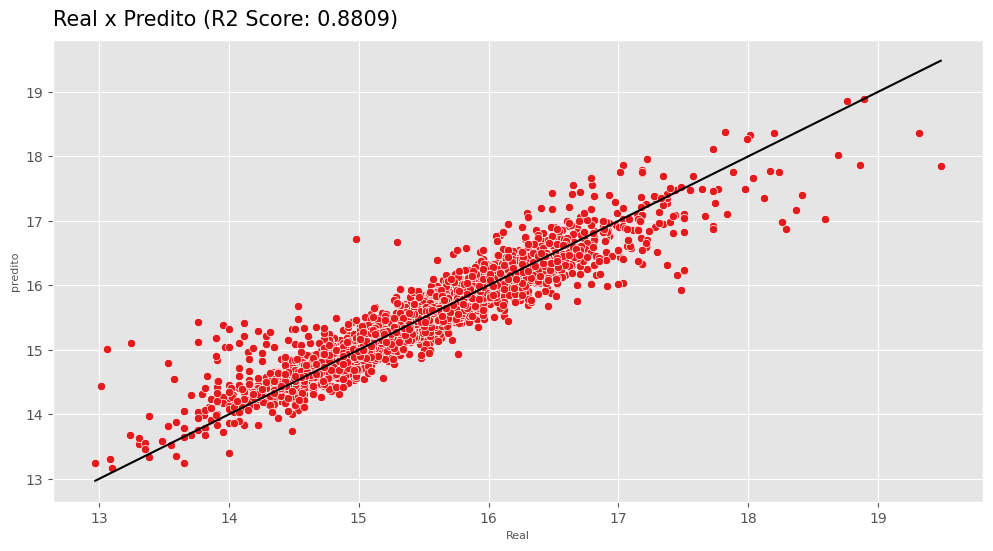

In [24]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.scatterplot(x = y_val, y = y_pred)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color = 'black')
ax.set_title(f"Real x Predito (R2 Score: {metrics.r2_score(y_val, y_pred):.4f})", fontsize = 15, pad = 10, loc = 'left')
ax.set_xlabel("Real", fontsize = 8)
ax.set_ylabel("predito", fontsize = 8)
plt.show()

Por conta da transformação em log, temos que pensar a interpetação das métricas de forma diferente:

- O R2 Score significa que o modelo explica cerca de 88.09% da variabilidade nos preços dos imóveis;
- O RMSE de 0.2244 significa que as previsões podem variar em torno de 22.44% para mais ou para menos do valor real;
- o MAE de 0.1482 indica que em média, as previsões têm um erro absoluto de cerca de 14.82% do valor real do imóvel.

Com este modelo base vamos buscar uma otimização para seus hiper-parâmetros. Em minha experiência como corretor de imóveis sempre usei a margem de negociação de 20% para mais ou menos então vamos tentar reduzir um pouco o Root Mean Squared Error para chegar a esta margem, além de potencialmente melhorar as outras métricas do modelo como o Mean Absolute Error. 

## 3.2. Otimização dos hiper-parâmetros

Vamos usar a biblioteca Optuna para realizar o ajuste dos hiper-parâmetros.

In [28]:
def objective(trial):
    model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        objective = 'reg:squarederror',
        n_estimators = trial.suggest_int("n_estimators", 100, 1000),
        learning_rate = trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        max_depth = trial.suggest_int("max_depth", 1, 10),
        subsample = trial.suggest_float("subsample", 0.05, 1.0),
        colsample_bytree = trial.suggest_float("colsample_bytree", 0.05, 1.0),
        min_child_weight = trial.suggest_int("min_child_weight", 1, 20),
        random_state = 21
    ))
    ])

    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    rmse = metrics.mean_squared_error(y_val, predictions, squared=False)
    return rmse

In [29]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2024-08-14 02:18:50,323] A new study created in memory with name: no-name-2650cfa3-2398-4ab2-9b18-3befc9d8b2f1
[I 2024-08-14 02:18:53,561] Trial 0 finished with value: 0.4912745083884372 and parameters: {'n_estimators': 653, 'learning_rate': 0.0015471004698524437, 'max_depth': 1, 'subsample': 0.21379314828012708, 'colsample_bytree': 0.7011002292360319, 'min_child_weight': 14}. Best is trial 0 with value: 0.4912745083884372.
[I 2024-08-14 02:19:03,389] Trial 1 finished with value: 0.21776355210595347 and parameters: {'n_estimators': 594, 'learning_rate': 0.0407799695719866, 'max_depth': 5, 'subsample': 0.8037594362800792, 'colsample_bytree': 0.9242946784097223, 'min_child_weight': 15}. Best is trial 1 with value: 0.21776355210595347.
[I 2024-08-14 02:19:15,242] Trial 2 finished with value: 0.22770761175683135 and parameters: {'n_estimators': 584, 'learning_rate': 0.02777719084715269, 'max_depth': 9, 'subsample': 0.05067847760784721, 'colsample_bytree': 0.3696810453127952, 'min_child_

In [30]:
print('Melhores hiper-parâmetros:', study.best_params)
print('Melhor RMSE:', study.best_value)

Melhores hiper-parâmetros: {'n_estimators': 867, 'learning_rate': 0.09396356090246702, 'max_depth': 6, 'subsample': 0.6955868105322172, 'colsample_bytree': 0.40079564093218806, 'min_child_weight': 3}
Melhor RMSE: 0.21076530063828172


In [31]:
reg_optuna = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(**study.best_params, random_state = 21))
])

reg_optuna.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('bool',
                                                  Pipeline(steps=[('bool_to_int',
                                                                   FunctionTransformer(func=<function bool_to_int at 0x7f3c56a03e20>)),
                                                                  ('imput',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['studio', 'open_plan']),
                                                 ('num',
                                                  Pipeline(steps=[('imput',
                                                                   MeanMedianImputer())]),
                                                  ['total_images', 'total_area',
                                                   'rooms', 'floors_total'...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.09396356090246702, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=6, max_leaves=None,
                              min_child_weight=3, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=867, n_jobs=None,
                              num_parallel_tree=None, random_state=21, ...))])

In [33]:
y_pred_optuna = reg_optuna.predict(X_val)

In [35]:
print(f"Métricas - Validação (Optuna)\n{"=" * 30}")
print(f"MSE: {metrics.mean_squared_error(y_val, y_pred_optuna):.4f}")
print(f"RMSE: {metrics.mean_squared_error(y_val, y_pred_optuna, squared = False):.4f}")
print(f"MAE: {metrics.mean_absolute_error(y_val, y_pred_optuna):.4f}")
print(f"R2 Score: {metrics.r2_score(y_val, y_pred_optuna):.4f}")

Métricas - Validação (Optuna)
MSE: 0.0444
RMSE: 0.2108
MAE: 0.1426
R2 Score: 0.8949


In [36]:
y_pred_test = reg_optuna.predict(X_test)

In [38]:
print(f"Métricas - Teste\n{"=" * 30}")
print(f"MSE: {metrics.mean_squared_error(y_test, y_pred_test):.4f}")
print(f"RMSE: {metrics.mean_squared_error(y_test, y_pred_test, squared = False):.4f}")
print(f"MAE: {metrics.mean_absolute_error(y_test, y_pred_test):.4f}")
print(f"R2 Score: {metrics.r2_score(y_test, y_pred_test):.4f}")

Métricas - Teste
MSE: 0.0557
RMSE: 0.2359
MAE: 0.1440
R2 Score: 0.8777


In [46]:
scoring = metrics.make_scorer(metrics.mean_absolute_error)
cv = KFold(n_splits = 5, shuffle=True, random_state=21)

scores = cross_val_score(reg_optuna, X_train, y_train, cv = cv, scoring = scoring)
print(f'Média do MAE: {scores}')
print(f'Média do MAE geral: {scores.mean()}')
print(f'Desvio padrão do MAE: {scores.std()}')

Média do MAE: [0.1455212  0.14275417 0.13708212 0.14757    0.14550289]
Média do MAE geral: 0.14368607345162948
Desvio padrão do MAE: 0.0036396165247448765


O modelo apresentou boa capacidade de generalização e pouca variância nos resultados da validação cruzada. Um erro médio de apenas 14% é algo dentro do esperado no mercado imobiliário, apesar de não termos chegado a um RMSE de 20% em teste ainda é um resultado bastante próximo e aceitável. 

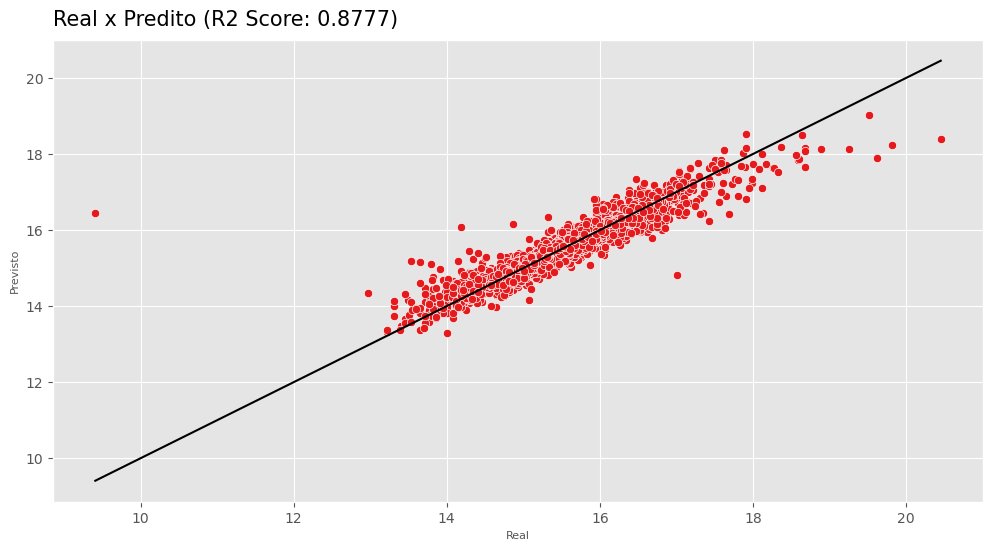

In [47]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.scatterplot(x = y_test, y = y_pred_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color = 'black')
ax.set_title(f"Real x Predito (R2 Score: {metrics.r2_score(y_test, y_pred_test):.4f})", fontsize = 15, pad = 10, loc = 'left')
ax.set_xlabel("Real", fontsize = 8)
ax.set_ylabel("Previsto", fontsize = 8)
plt.show()

## 3.3. Feature Importances

Agora vamos observar as features que mais ajudam o modelo a fazer predições precisas. 

In [48]:
regressor = reg_optuna.named_steps['regressor']
importances = regressor.feature_importances_

In [49]:
all_features = X_train.columns.to_list()
feature_importances = regressor.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': all_features,
    'importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by = 'importance', ascending = False)

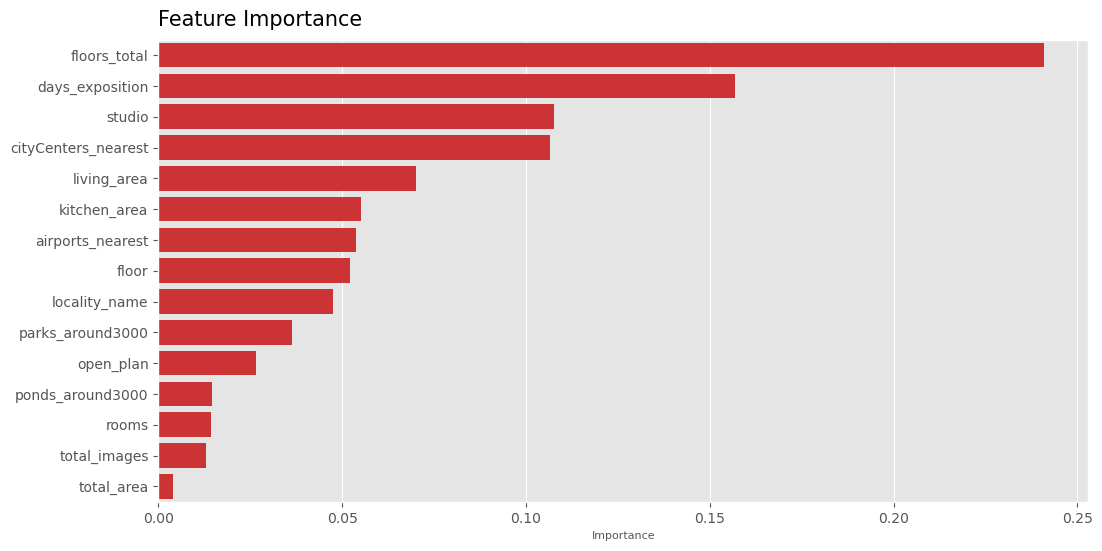

In [50]:
fig, ax = plt.subplots(figsize = (12, 6))

sns.barplot(feature_importance_df, y = 'feature', x = 'importance')
ax.set_title("Feature Importance", fontsize = 15, pad = 10, loc = 'left')
ax.set_xlabel("Importance", fontsize = 8)
ax.set_ylabel("")
plt.show()